In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from operator import itemgetter
import os

from umap import UMAP
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

We load data produced in the **1_data_production** notebook, specifically:
- Largest Viable Component size
- page-rank node percolation critical point 
- number of modules and modularity from DCSBM

In [2]:
working_dir = "data/"

# storage dictionaries, one for each data type
lvcs, crit_points, mods, mody = {} , {}, {}, {}
file_names = np.sort(os.listdir(working_dir+"LVC/original/"))
names = np.array([f[:-4] for f in file_names])
for file in file_names:
    lvcs[file[:-4]] = np.loadtxt(working_dir+"LVC/original/"+file, dtype=int)
    crit_points[file[:-4]] = np.loadtxt(working_dir+"percolation/original/"+file, dtype=float)
    mods[file[:-4]] = np.loadtxt(working_dir+"modules/original/"+file, dtype=int)
    mody[file[:-4]] = np.loadtxt(working_dir+"modularity/original/"+file, dtype=float)

# get sizes of the combination sets
sizes = {f:len(lvcs[f]) for f in lvcs}

Boxplot of the distribution of the quantities divided into the combination sets used as Fig.3 in the article

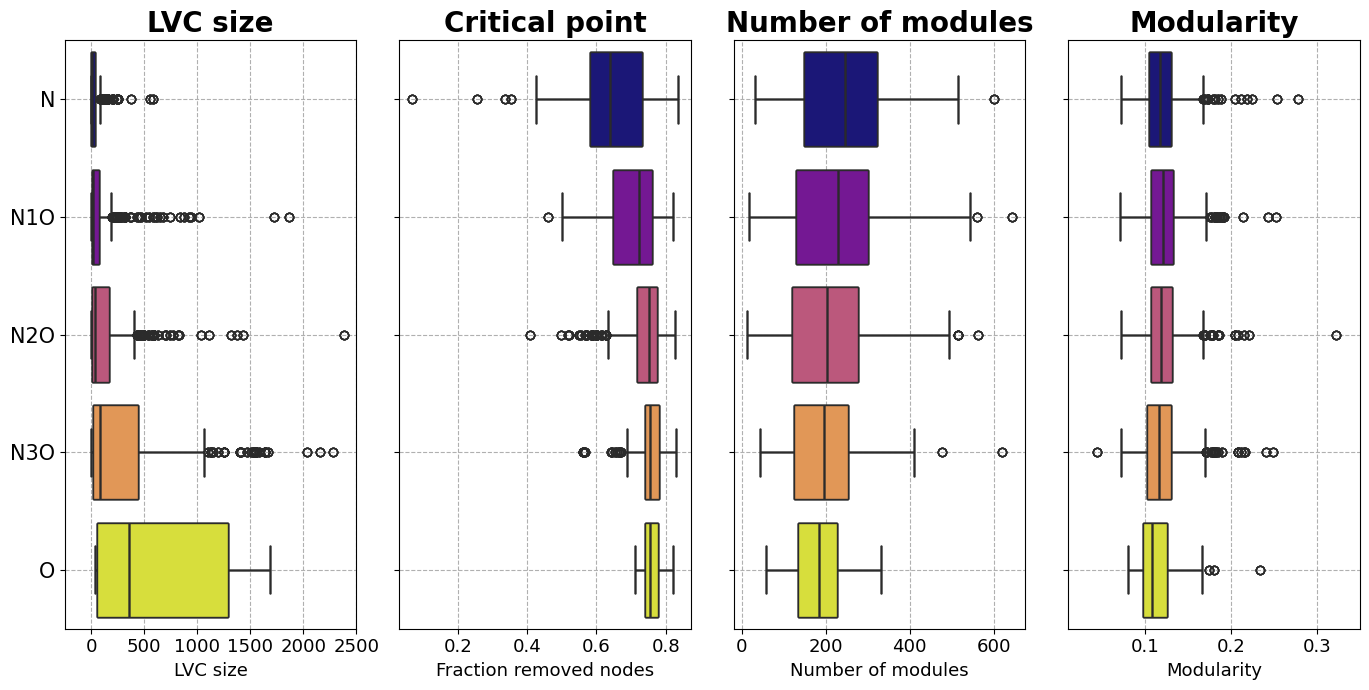

In [11]:
plt.figure(figsize=(14,7))

# LVC size
plt.subplot(1,4,1)
data = [lvcs[key] for key in lvcs.keys()]
names = list(lvcs.keys())
for i in range(len(names)):
    sns.boxplot(data = {"lab": np.concatenate([[i]*len(data[i]) for i in range(len(data))]), "med":np.concatenate(data)}, 
                    y = "lab",
                    x = "med", 
                    hue = "lab",
                    palette="plasma", orient="horizontal", legend=False)
plt.title("LVC size", fontsize=20, fontweight="bold")
plt.yticks(np.arange(len(names)), labels=[n.upper() for n in names], fontsize=15)
plt.xticks(fontsize=13)
plt.xlabel("LVC size", fontsize=13)
plt.ylabel("")
plt.xlim(-250, 2500)
plt.grid(ls="--")
plt.tight_layout()

# Critical point
plt.subplot(1,4,2)
data = [1-crit_points[key] for key in crit_points.keys()]
names = list(crit_points.keys())
for i in range(len(names)):
    sns.boxplot(data = {"lab": np.concatenate([[i]*len(data[i]) for i in range(len(data))]), "med":np.concatenate(data)}, 
                    y = "lab",
                    x = "med", 
                    hue = "lab",
                    palette="plasma", orient="horizontal", legend=False)
plt.title("Critical point", fontsize=20, fontweight="bold")
plt.yticks(np.arange(len(names)), labels="")
plt.xticks(fontsize=13)
plt.xlabel("Fraction removed nodes", fontsize=13)
plt.ylabel("")
plt.grid(ls="--")
plt.tight_layout()

# Number of modules
plt.subplot(1,4,3)
data = [mods[key] for key in mods.keys()]
names = list(mods.keys())
for i in range(len(names)):
    sns.boxplot(data = {"lab": np.concatenate([[i]*len(data[i]) for i in range(len(data))]), "med":np.concatenate(data)}, 
                    y = "lab",
                    x = "med", 
                    hue = "lab",
                    palette="plasma", orient="horizontal", legend=False)
plt.title("Number of modules", fontsize=20, fontweight="bold")
plt.yticks(np.arange(len(names)), labels="")
plt.xticks(fontsize=13)
plt.xlabel("Number of modules", fontsize=13)
plt.ylabel("")
plt.grid(ls="--")
plt.tight_layout()

# Modularity
plt.subplot(1,4,4)
data = [mody[key] for key in mody.keys()]
names = list(mody.keys())
for i in range(len(names)):
    sns.boxplot(data = {"lab": np.concatenate([[i]*len(data[i]) for i in range(len(data))]), "med":np.concatenate(data)}, 
                    y = "lab",
                    x = "med", 
                    hue = "lab",
                    palette="plasma", orient="horizontal", legend=False)
plt.title("Modularity", fontsize=20, fontweight="bold")
plt.yticks(np.arange(len(names)), labels="")
plt.xticks(fontsize=13)
plt.xlabel("Modularity", fontsize=13)
plt.ylabel("")
plt.xlim(0.01, 0.35)
plt.grid(ls="--")
plt.tight_layout()

This section focuses on combining topological parameters to **distinguish between different combination sets**. By applying the **UMAP** algorithm for dimensionality reduction, we aim to project the selected features into a lower-dimensional space, facilitating the identification of "oncogenic" and "non-oncogenic" regions within the data.

For the classification we use a SVM to distinguish regions of the parameter space associated to the *O* and *N* combination set.

In [9]:
# organize all the data in a single object of dimension (n_features, n_combination_sets)
data = [[d[key] for key in d.keys()] for d in [lvcs, crit_points, mods, mody]]

# rearrange in to have vectors of dimension (n_combination_sets, n_features)
data_all = []
for i in range(len(data[0])):
    data_all.append([])
    for j in range(len(data)):
        data_all[i].append(data[j][i])
    data_all[i] = np.array(data_all[i])
data_all = np.concatenate(data_all, axis=1) # final shape (n_combination_sets, n_features)

/home/francesco/anaconda3/envs/compl/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


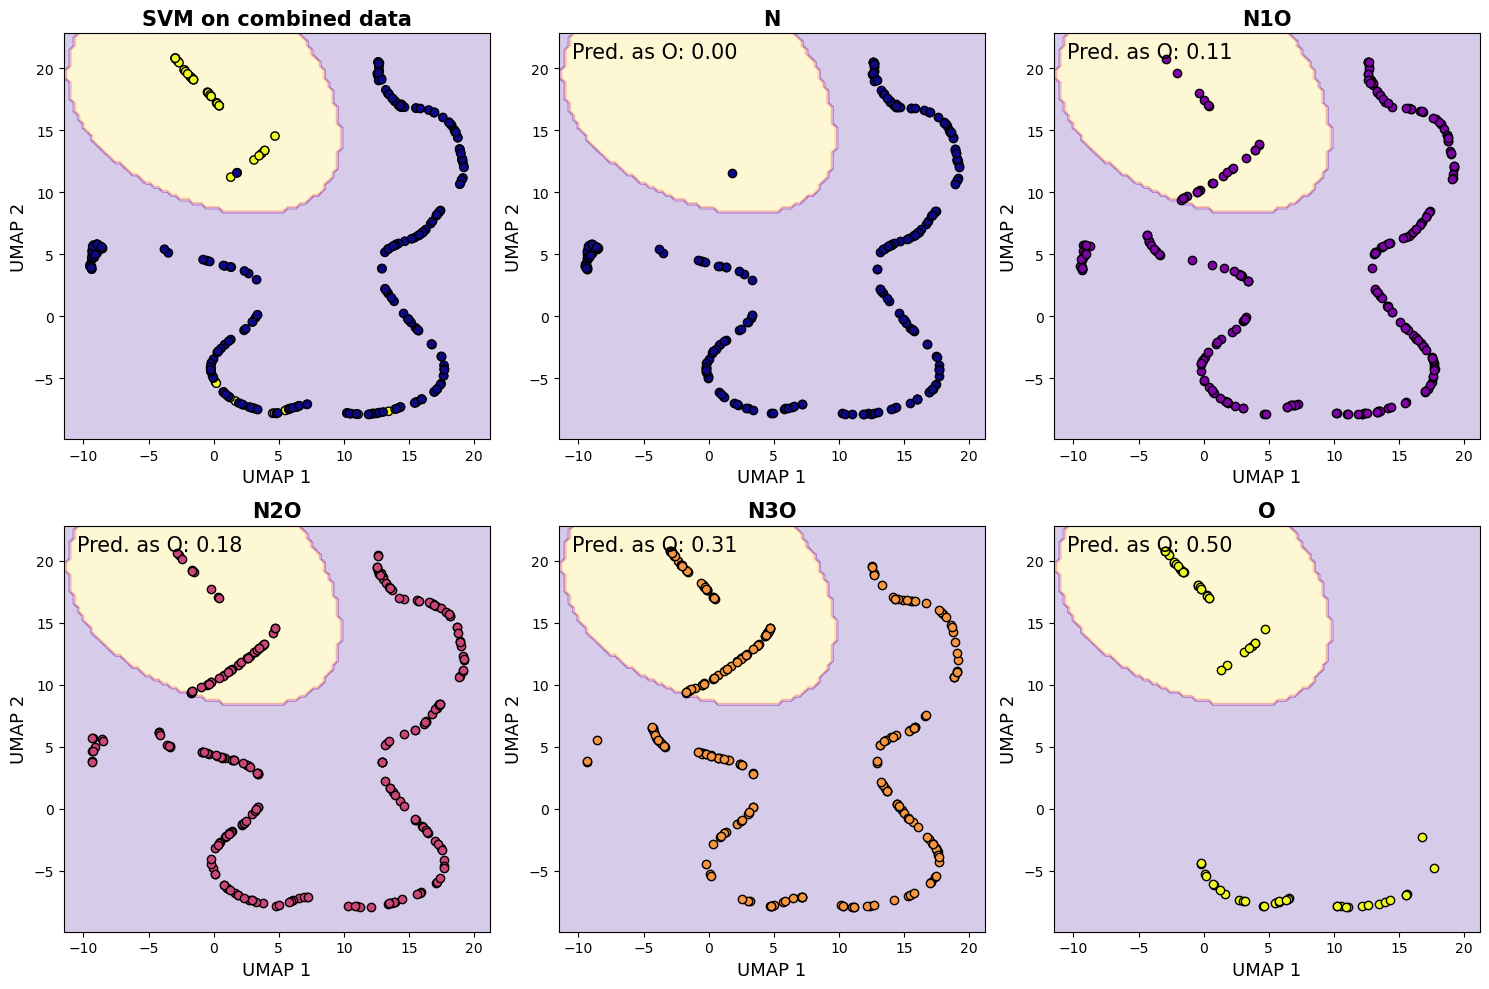

In [10]:
# Apply UMAP for dimensionality reduction
reducer = UMAP(random_state=1234)
scaler = StandardScaler() # scale data before UMAP
data_scaled = scaler.fit_transform(data_all)
embedding = reducer.fit_transform(data_scaled.T)

# Prepare data for SVM classification, considering only O and N combination sets
X = np.concatenate([embedding[-sizes['o']:,:], embedding[:sizes['n'],:]], axis=0)
y = np.concatenate([[0]*sizes['o'],[1]*sizes['n']]) # 0 for O, 1 for N

# Create an SVM classifier with RBF kernel
classifier = SVC(kernel='rbf')

# Train the classifier
classifier.fit(X, y)

# Define plot limits
xlims = (X[:,0].min()-2, X[:,0].max()+2)
ylims = (X[:,1].min()-2, X[:,1].max()+2)

# Create a meshgrid to plot the decision boundary
xx, yy = np.meshgrid(np.linspace(xlims[0], xlims[1], 100),
                     np.linspace(ylims[0], ylims[1], 100))

# Predict the labels for the meshgrid points
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predicted labels to match the meshgrid shape
Z = Z.reshape(xx.shape)

# Plotting

# Define colors for each combination set
colors = {file_names[i][:-4]: sns.color_palette("plasma", as_cmap=True)(np.linspace(0, 1, len(file_names)))[i] for i in range(len(file_names))}
c = itemgetter(*np.concatenate([['o']*sizes["o"]+['n']*sizes["n"]]))(colors)

_ , ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

# Plot combined data with decision boundary
ax[0].scatter(X[:,0], X[:,1], c=c, edgecolors='k', zorder=2)
ax[0].contourf(xx, yy, Z, cmap=plt.cm.plasma_r, alpha=0.2)

# Plot each combination set separately with decision boundary and classification result
for i in range(len(file_names)):
    lim0 = np.sum([sizes[names[j]] for j in range(i)]).astype(int)
    lim1 = int(lim0 + sizes[names[i]])
    ax[i+1].scatter(embedding[lim0:lim1,0], embedding[lim0:lim1,1], 
                    color=colors[file_names[i][:-4]], edgecolors='k', zorder=2)
    ax[i+1].contourf(xx, yy, Z, cmap=cm.plasma_r, alpha=0.2)
    class_res = 1-classifier.score(embedding[lim0:lim1,:], np.concatenate([[1]*sizes[names[i]]]))
    ax[i+1].text(xlims[0]+1, ylims[1]-2, f'Pred. as O: {class_res:.2f}', fontsize=15)
[axi.set_xlabel('UMAP 1', fontsize=13) for axi in ax]
[axi.set_ylabel('UMAP 2', fontsize=13) for axi in ax]
ax[0].set_title('SVM on combined data', fontsize=15, fontweight="bold")
[ax[i+1].set_title(f'{file_names[i][:-4].upper()}', fontsize=15, fontweight="bold") for i in range(len(file_names))]
[axi.set_xlim(xlims) for axi in ax]
[axi.set_ylim(ylims) for axi in ax]
plt.tight_layout()
plt.show()